# Car Price Predictor

## Importing Libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np
import time

# For plotting 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For encoding categorical data
from sklearn.preprocessing import LabelEncoder
# Cross validation and hyperparameter tuning
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
# Machine Learning models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
# Metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score

## Importing and Cleaning Data

In [2]:
# Gathering the Data
audi = pd.read_csv('audi.csv')
bmw = pd.read_csv('bmw.csv')
ford = pd.read_csv('ford.csv')
hyundi = pd.read_csv('hyundi.csv')
merc = pd.read_csv('merc.csv')
skoda = pd.read_csv('skoda.csv')
toyota = pd.read_csv('toyota.csv')
vauxhall = pd.read_csv('vauxhall.csv')
vw = pd.read_csv('vw.csv')

# Adding the company columns to the data frames
audi['company'] = 'Audi'
bmw['company'] = 'BMW'
ford['company'] = 'Ford'
hyundi['company'] = 'Hyundai'
merc['company'] = 'Mercedes'
skoda['company'] = 'Skoda'
toyota['company'] = 'Toyota'
vauxhall['company'] = 'Vauxhall'
vw['company'] = 'Volkswagen'

# Append all the data into one dataframe
df = audi.append([bmw, ford, hyundi, merc, skoda, toyota, vauxhall, vw], sort=False)

# Move the company column to the left
df = df[ ['company'] + [ col for col in df.columns if col != 'company' ] ]
# Move the price column to the right
df = df[ [ col for col in df.columns if col != 'price' ] + ['price'] ]

# Removing empty spaces
for i in df.columns:
    if df[i].dtypes == 'O':
        df[i] = df[i].str.strip()
        
df.head()

,company,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,tax(£),price
0,Audi,A1,2017,Manual,15735,Petrol,150.0,55.4,1.4,NaN,12500
1,Audi,A6,2016,Automatic,36203,Diesel,20.0,64.2,2.0,NaN,16500
2,Audi,A1,2016,Manual,29946,Petrol,30.0,55.4,1.4,NaN,11000
3,Audi,A4,2017,Automatic,25952,Diesel,145.0,67.3,2.0,NaN,16800
4,Audi,A3,2019,Manual,1998,Petrol,145.0,49.6,1.0,NaN,17300


In [3]:
# Checking for any null values
df.isnull().sum()

company             0
model               0
year                0
transmission        0
mileage             0
fuelType            0
tax              4860
mpg                 0
engineSize          0
tax(£)          94327
price               0
dtype: int64

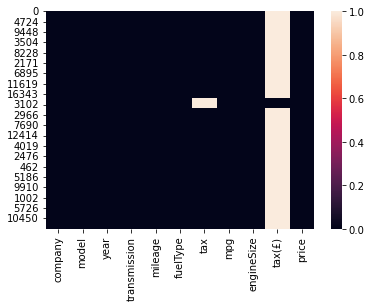

In [4]:
# Heatmap of null values
sns.heatmap(df.isnull())
plt.show()

In [5]:
# Filling null values of tax column with tax(£) column
df['tax'] = df['tax'].fillna(df['tax(£)'])
# Dropping not needed column
df = df.drop(columns=['tax(£)'])

In [6]:
# Getting data statistics
df.describe()

,year,mileage,tax,mpg,engineSize,price
count,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000
mean,2017.087723,23058.914213,120.299838,55.166825,1.663280,16805.347656
std,2.123934,21148.523721,63.150926,16.138522,0.557646,9866.773417
min,1970.000000,1.000000,0.000000,0.300000,0.000000,450.000000
25%,2016.000000,7425.000000,125.000000,47.100000,1.200000,9999.000000
50%,2017.000000,17460.000000,145.000000,54.300000,1.600000,14495.000000
75%,2019.000000,32339.000000,145.000000,62.800000,2.000000,20870.000000
max,2060.000000,323000.000000,580.000000,470.800000,6.600000,159999.000000


In [7]:
# Removing 2060 year row
df = df.loc[df['year'] <= 2020]

In [8]:
# Ensuring engine size of zero are only electric
df.loc[df['engineSize'] == 0]['fuelType'].describe()

count        273
unique         5
top       Petrol
freq         163
Name: fuelType, dtype: object

In [9]:
# It is clear that the majority of cars with an engine size of zero are not electric, therefore will be removed
df = df.loc[df['engineSize'] != 0]

In [10]:
# Checking for electric cars
df.loc[df['fuelType'] == 'Electric']

,company,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
8835,BMW,i3,2015,Automatic,29465,Electric,0.0,470.8,1.0,17400
6385,Ford,Mondeo,2016,Automatic,9396,Electric,0.0,67.3,2.0,15975
11959,Ford,Mondeo,2016,Automatic,24531,Electric,0.0,67.3,2.0,15500
13317,Vauxhall,Ampera,2015,Automatic,34461,Electric,0.0,235.4,1.4,12999


In [11]:
# It would be best to remove the electrical cars
df = df.loc[df['fuelType'] != 'Electric']

In [12]:
# Ensuring the data types are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98909 entries, 0 to 15156
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       98909 non-null  object 
 1   model         98909 non-null  object 
 2   year          98909 non-null  int64  
 3   transmission  98909 non-null  object 
 4   mileage       98909 non-null  int64  
 5   fuelType      98909 non-null  object 
 6   tax           98909 non-null  float64
 7   mpg           98909 non-null  float64
 8   engineSize    98909 non-null  float64
 9   price         98909 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 8.3+ MB


## Exploratory Data Analysis (EDA)

###### Company and Price

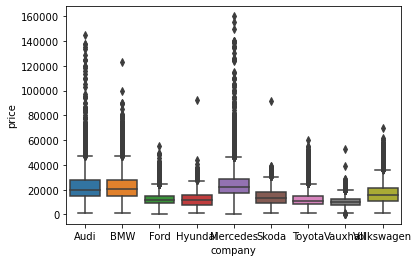

In [13]:
sns.boxplot(data=df, x='company', y='price')
plt.show()

In [14]:
# Length before removing outliers
len(df)

98909

In [15]:
company_outliers ={ # Manually listing the outliers
    'BMW' : 100000,
    'Hyundai' : 60000,
    'Skoda' : 60000,
    'Vauxhall' : 30000,
}
# Removing outliers based on company_outliers
for company in list(company_outliers):
    value = company_outliers[company]
    df = df.loc[~((df['price'] > value) & (df['company'] == company))]
# Length after removing outliers
len(df)    

98904

###### Year and Price

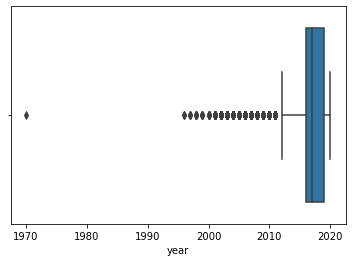

In [16]:
sns.boxplot(x=df['year'])
plt.show()

In [17]:
df = df.loc[df['year'] > 1970]
len(df)

98903

###### Mileage and Price

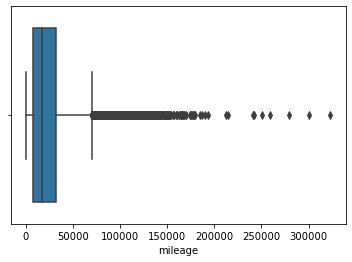

In [18]:
sns.boxplot(x=df['mileage'])
plt.show()

In [19]:
df = df.loc[df['mileage'] < 200000]
len(df)

98894

###### Miles per Gallon and Price

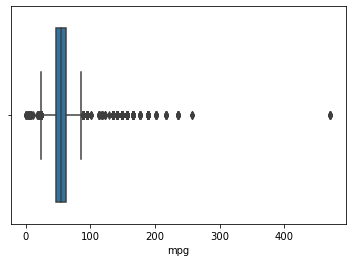

In [20]:
sns.boxplot(x=df['mpg'])
plt.show()

In [21]:
df = df.loc[df['mpg'] < 300]
len(df)

98887

The chart shows that there is an increase in price the less the miles per gallon is.

###### Tax and Price

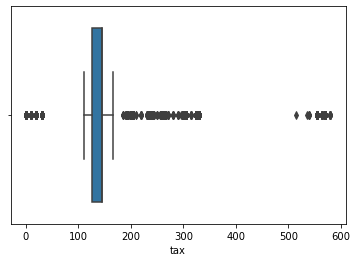

In [22]:
sns.boxplot(x=df['tax'])
plt.show()

There seems to be no correlation between the price and tax. Therefore, we can remove this column.

###### Engine Size and Price

/Users/farishanna/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


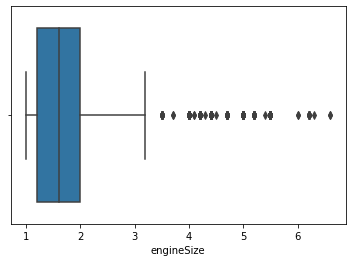

In [23]:
sns.boxplot(df['engineSize'])
plt.show()

There is not much correlation between the engine size and the price. Only that usually more expensive cars can have a large engine size.

###### Transmission and Price

In [24]:
def cat_clean(column):
    # Creates pivot table of the mean of prices of each transmission type
    table = pd.pivot_table(df, values='price', index=[column], aggfunc='count')
    # Creating pie chart
    plt.pie(table.price, labels=table.index)
    # Adding title
    plt.title('Counts of cars by ' + column)
    # Showing graph
    plt.show()

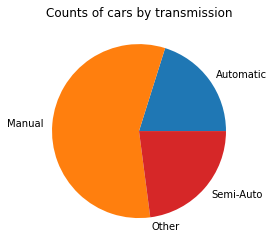

In [25]:
cat_clean('transmission')

In [26]:
df = df.loc[df['transmission'] != 'Other']
len(df) 

98879

###### Fuel Type and Price

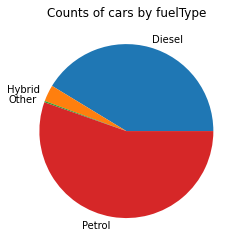

In [27]:
cat_clean('fuelType')

In [28]:
df = df.loc[df['fuelType'] != 'Other']
len(df)

98640

###### Further analysis

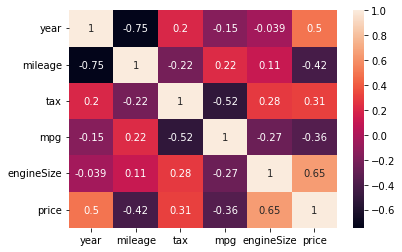

In [29]:
# Checking for any correlations in the dataframe using a heatmap
sns.heatmap(df.corr(), annot=True)
plt.show()

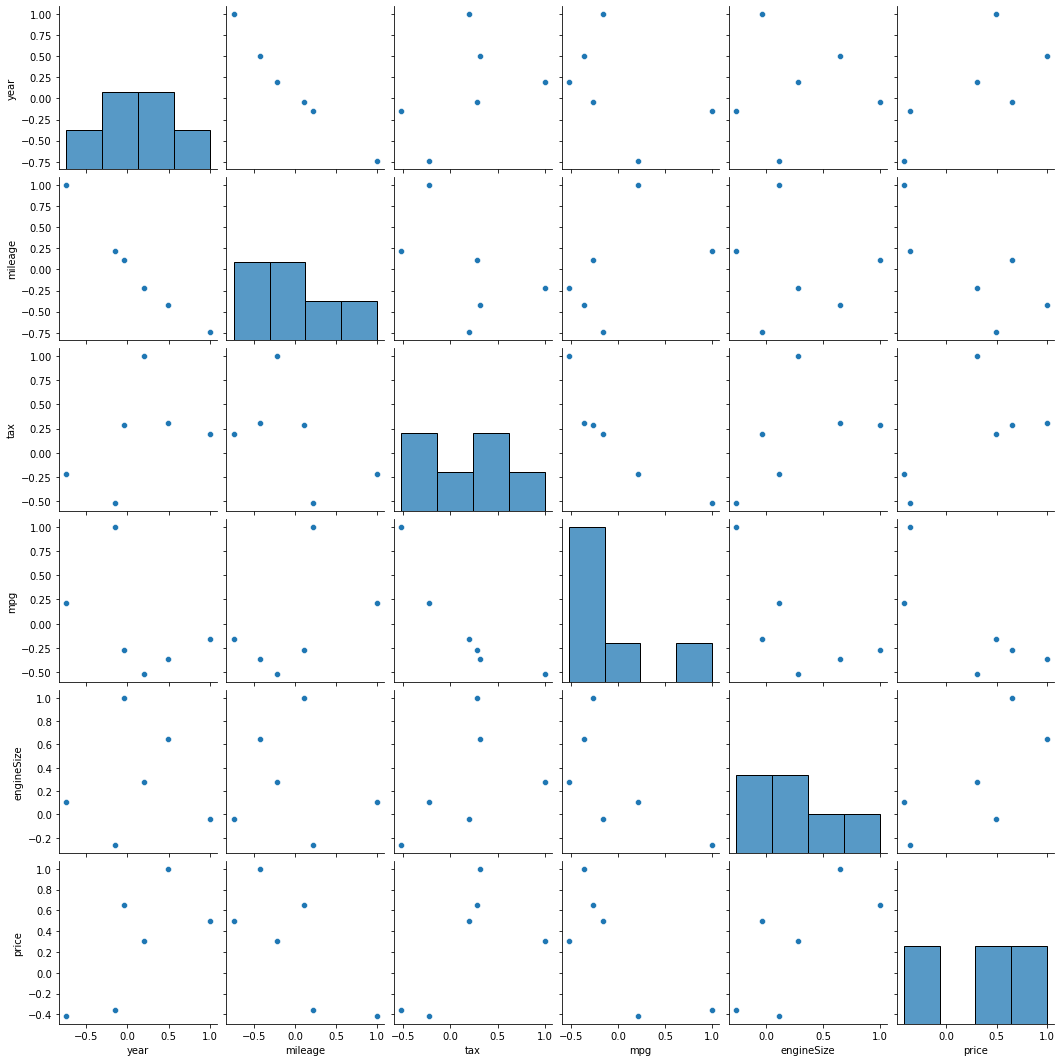

In [30]:
sns.pairplot(df.corr())
plt.show()

## Data Pre-Processing

In [31]:
# # Splitting target variable (price) and independent variables
X = df.drop(columns=['price'])
Y = df['price'].values

In [32]:
# Encoding the categorical data into integers
le = LabelEncoder()
def encode(df_le):
    df_le['company'] = le.fit_transform(df_le['company'])
    df_le['model'] = le.fit_transform(df_le['model'])
    df_le['transmission'] = le.fit_transform(df_le['transmission'])
    df_le['fuelType'] = le.fit_transform(df_le['fuelType'])
    return df_le

X = encode(X)
X.head()

,company,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,0,12,2017,1,15735,2,150.0,55.4,1.4
1,0,17,2016,0,36203,0,20.0,64.2,2.0
2,0,12,2016,1,29946,2,30.0,55.4,1.4
3,0,15,2017,0,25952,0,145.0,67.3,2.0
4,0,14,2019,1,1998,2,145.0,49.6,1.0


In [33]:
# K fold splitting training and testing data
kf = KFold(n_splits=5, shuffle=True)
# Turning features to array
X=X.values

## Model Implementation

In [34]:
# Function that will score models' scores in the dictionary, and will plot the models' accuracy
def evaluate_model(model, x, y, return_r2=False, return_cvscore=False, grid=False):
    
    # K fold splitting training and testing data
    for train, test in kf.split(x):
        X_train, X_test, y_train, y_test = x[train], x[test], y[train], y[test]
        
    # Timing and fitting the training data
    start_time = time.time() 
    # Fit the model using the training data
    model.fit(X_train, y_train)
    time_taken = time.time() - start_time
    # Predict the test data
    y_pred = model.predict(X_test)

    # Model metrics
    r2 = str(round(r2_score(y_test, y_pred)*100,2))+'%'
    # Cross Validation         
    cvrmse = -1*cross_val_score(model,x, y,cv=kf,
                             scoring='neg_root_mean_squared_error')
    cvscore = round(np.median(cvrmse),2)
    # Return rmse when specified
    if(return_cvscore == True):
        return cvscore
    # Displaying scores
    print(f"R2 SCORE: {r2}\t",
          f"CV (RMSE) Score: {cvscore}\t",
          f"\tTime taken in seconds: {round((time_taken),2)}\n")
    
    # Print best params if gridsearch is used
    if(grid==True):
        print('Best Parameters: ', model.best_params_, '\n')    
    
    # Plotting regression and boxplot
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    # Plotting chart
    results = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
    lm=sns.regplot(x='Actual',y='Predicted',data=results, fit_reg=False, ax=ax[0])
    # Plotting line
    line = np.arange(results.min().min(), results.max().max())
    ax[0].plot(line, line, color='red')
    ax[0].set_title('Actual vs Predicted')
    # Cross validation results in boxplot (rmse)
    sns.boxplot(x=cvrmse, ax=ax[1])
    ax[1].set_title('CV results of rmse score')
    plt.show()

#### Linear Regression

Linear Regression
R2 SCORE: 73.84%	 CV (RMSE) Score: 5055.05	 	Time taken in seconds: 0.02



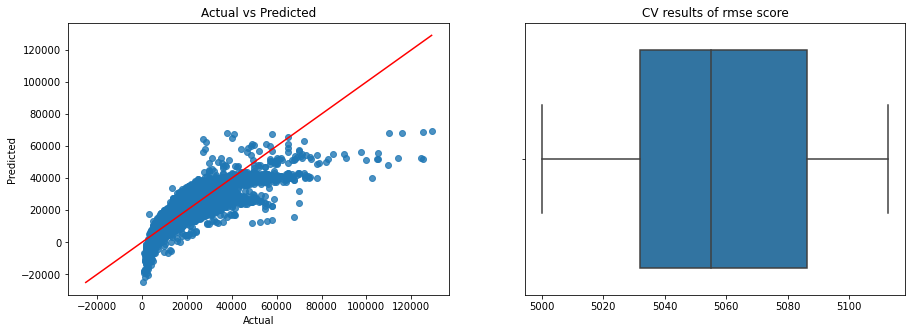

In [35]:
model = LinearRegression()
print('Linear Regression')
evaluate_model(model, X, Y)

#### Decision Tree Regression

Decision Tree Regression
R2 SCORE: 93.79%	 CV (RMSE) Score: 2526.11	 	Time taken in seconds: 0.34



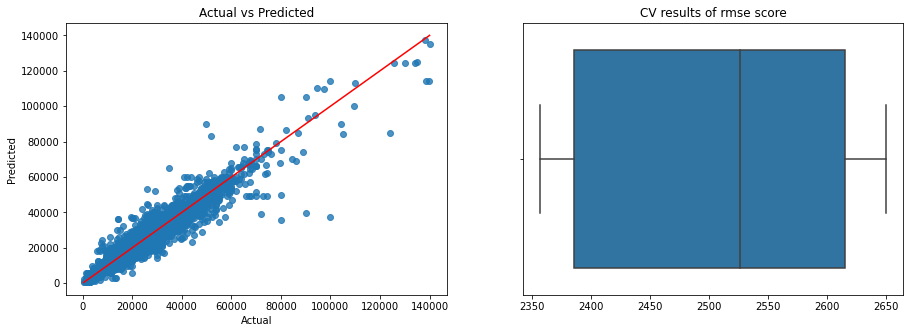

In [36]:
model = DecisionTreeRegressor()
print('Decision Tree Regression')
evaluate_model(model, X, Y)

#### CatBoost Regressor

CatBoost Regression
R2 SCORE: 96.22%	 CV (RMSE) Score: 1882.96	 	Time taken in seconds: 6.32



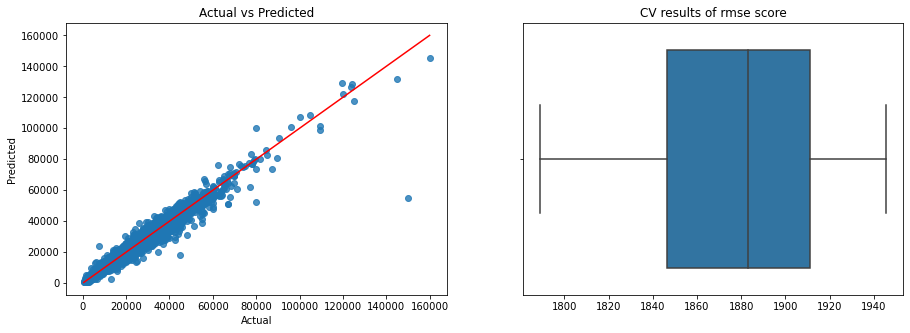

In [37]:
model = CatBoostRegressor(silent=True)
print('CatBoost Regression')
evaluate_model(model, X, Y)

## Model Tuning

#### Feature Selection

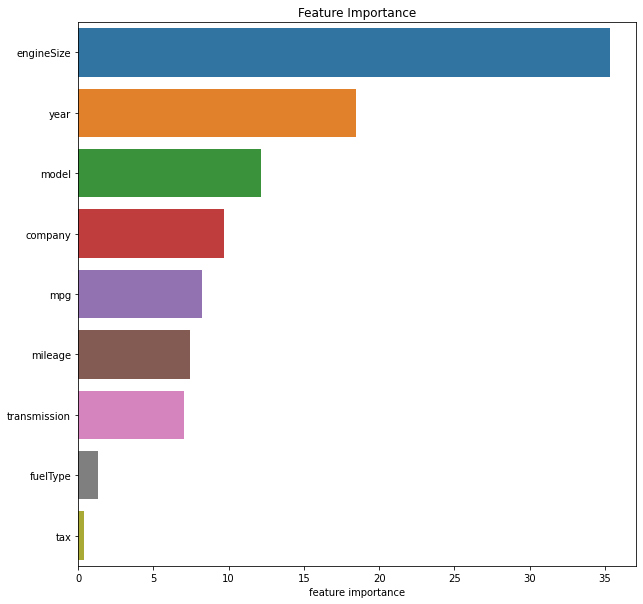

In [38]:
# Feature importance of model
feature_imp = pd.DataFrame(model.get_feature_importance())
feature_imp.index = df.drop(columns=['price']).columns
feature_imp.columns = ['feature importance']
feature_imp=feature_imp.sort_values(by='feature importance', ascending=False)
# Plot 
plt.subplots(figsize=(10,10))
sns.barplot(x=feature_imp['feature importance'], y=feature_imp.index)
plt.title('Feature Importance')
plt.show()

In [42]:
x=encode(df.drop(columns=['price']))
# RMSE CV Score median without fueltype 
x_fs = x.drop(columns=['fuelType']).values 
ft_score = evaluate_model(model, x_fs, Y, return_cvscore=True)
print('Without fueltype:', ft_score)
# Without both fuel type and tax
x_fs = x.drop(columns=['fuelType', 'tax']).values 
both_score = evaluate_model(model, x_fs, Y, return_cvscore=True)
print('Without tax & ft:', both_score)
# RMSE CV Score median without tax 
x_fs = x.drop(columns=['tax']).values 
tax_score = evaluate_model(model, x_fs, Y, return_cvscore=True)
print('Without tax: ', tax_score)

Without fueltype: 1902.93
Without tax & ft: 1874.99
Without tax:  1848.02


Only tax to be removed

#### GridSearchCV

Parameter tuning results
R2 SCORE: 97.24%	 CV (RMSE) Score: 1678.97	 	Time taken in seconds: 58.96

Best Parameters:  {'depth': 8, 'iterations': 1250, 'learning_rate': 0.33} 



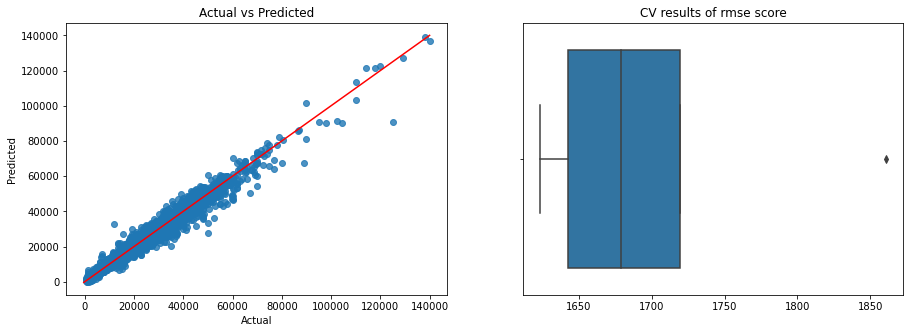

In [43]:
# Gridsearch to get best parameters
parameters = { 
'learning_rate': [0.33,1],
'depth': [6,8],
'iterations': [250,750,1250]
} # Best params: 0.33, 8, 1250

# Optimizing pipeline using GridSearchCV
grid = GridSearchCV(model, parameters, cv=kf)
print('Parameter tuning results')
evaluate_model(grid, x_fs, Y, grid=True)


## UI Form with Model

In [44]:
def model_ui():    
    # Extracting user inputs, and changing data types when appropriate
    print("------------------Please enter the details of the car---------------------------\n")
    print("Please choose one of the following Car Companies:\n")
    i=0
    for company in df.company.unique(): 
        i=i+1
        print(str(i) + '. ' + str(company)) # Displays all the car companies
    
    company = input("\nCompany of Car: ")
    dfi = df.loc[df['company'] == company] # Get data of specific company

    print('----------------------------------------------------------------------------------')
    print('\nPlease choose one of the following Car Models:\n')
    i=0
    for model in dfi.model.unique(): # Models of the specified company
        i=i+1
        print(str(i) + '. ' + model) # Display all models of company

    model = input("\nModel of Car: ") # Takes the model
    print('----------------------------------------------------------------------------------')
    year = int(input("\nYear of Car: ")) # Takes the year

    print('----------------------------------------------------------------------------------')
    print('\nPlease choose one of the following Transmissions:\n')
    i=0
    for transmission in dfi.transmission.unique(): # Transmissions of the specified company
        i=i+1
        print(str(i) + '. ' + transmission) # Displays transmissions 
    
    transmission = input("\nTransmission of Car: ")
    print('----------------------------------------------------------------------------------')
    mileage = int(input("\nMileage driven by car: ")) # Takes mileage

    print('----------------------------------------------------------------------------------')
    print('\nPlease choose one of the following Fuel Types:\n')
    i=0
    for fueltype in dfi.fuelType.unique(): # Fuel types of specified company
        i=i+1
        print(str(i) + '. ' + fueltype) # Displays fueltypes
    fuelType = input("\nFuel Type of Car: ")
   
    print('----------------------------------------------------------------------------------')
    mpg = float(input("\nMiles per Gallon of Car: ")) # Takes car mpg
    
    print('----------------------------------------------------------------------------------')
    engineSize = float(input("\nEngine Size of Car in Litres: ")) # Takes Engine Size
    
    print('----------------------------------------------------------------------------------')
    print('\nPredicting Price...') # For UI purposes
    
    # Turning inputs into a pandas df, to merge with the original df
    df_ui = pd.DataFrame({'company':[company],
                          'model':[model],
                          'year':[year],
                          'transmission':[transmission],
                          'mileage':[mileage],
                          'fuelType':[fuelType],
                          'tax':[0],
                          'mpg':[mpg],
                          'engineSize':[engineSize]})
    
    # Splitting target variable and independent variables
    X = df.drop(columns=['price'])
    Y = df['price']
    # Concatenate independent variables (X) with input
    X = pd.concat([df_ui,X], ignore_index=True)
    # Encoding data
    X = encode(X)
    # Removing tax
    X=X.drop(columns=['tax'])
    # Extracting input row with encoding
    X_pred = X.iloc[[0]]
    # Predict user input
    output = grid.predict(X_pred)
    # Display prediction
    print('\nThe predicted price of the car is worth:', "\033[1m"+'£'+str(int(output[0]))+"\033[0m")

## Test Cases

#### Test Case 1: Company

Mercedes

In [45]:
model_ui()

------------------Please enter the details of the car---------------------------

Please choose one of the following Car Companies:

1. Audi
2. BMW
3. Ford
4. Hyundai
5. Mercedes
6. Skoda
7. Toyota
8. Vauxhall
9. Volkswagen

Company of Car: Mercedes
----------------------------------------------------------------------------------

Please choose one of the following Car Models:

1. SLK
2. S Class
3. SL CLASS
4. G Class
5. GLE Class
6. GLA Class
7. A Class
8. B Class
9. GLC Class
10. C Class
11. E Class
12. GL Class
13. CLS Class
14. CLC Class
15. CLA Class
16. V Class
17. M Class
18. CL Class
19. GLS Class
20. GLB Class
21. X-CLASS
22. 180
23. CLK
24. R Class
25. 220
26. 200

Model of Car: C Class
----------------------------------------------------------------------------------

Year of Car: 2015
----------------------------------------------------------------------------------

Please choose one of the following Transmissions:

1. Automatic
2. Manual
3. Semi-Auto

Transmission of Car

Skoda

In [46]:
model_ui()

------------------Please enter the details of the car---------------------------

Please choose one of the following Car Companies:

1. Audi
2. BMW
3. Ford
4. Hyundai
5. Mercedes
6. Skoda
7. Toyota
8. Vauxhall
9. Volkswagen

Company of Car: Skoda
----------------------------------------------------------------------------------

Please choose one of the following Car Models:

1. Octavia
2. Citigo
3. Yeti Outdoor
4. Superb
5. Kodiaq
6. Rapid
7. Karoq
8. Fabia
9. Yeti
10. Scala
11. Roomster
12. Kamiq

Model of Car: Octavia
----------------------------------------------------------------------------------

Year of Car: 2015
----------------------------------------------------------------------------------

Please choose one of the following Transmissions:

1. Manual
2. Automatic
3. Semi-Auto

Transmission of Car: Automatic
----------------------------------------------------------------------------------

Mileage driven by car: 1000
--------------------------------------------------------

Test successful

#### Test Case 2: Mileage

100

In [48]:
model_ui()

------------------Please enter the details of the car---------------------------

Please choose one of the following Car Companies:

1. Audi
2. BMW
3. Ford
4. Hyundai
5. Mercedes
6. Skoda
7. Toyota
8. Vauxhall
9. Volkswagen

Company of Car: Audi
----------------------------------------------------------------------------------

Please choose one of the following Car Models:

1. A1
2. A6
3. A4
4. A3
5. Q3
6. Q5
7. A5
8. S4
9. Q2
10. A7
11. TT
12. Q7
13. RS6
14. RS3
15. A8
16. Q8
17. RS4
18. RS5
19. R8
20. SQ5
21. S8
22. SQ7
23. S3
24. S5
25. A2
26. RS7

Model of Car: A1
----------------------------------------------------------------------------------

Year of Car: 2015
----------------------------------------------------------------------------------

Please choose one of the following Transmissions:

1. Manual
2. Automatic
3. Semi-Auto

Transmission of Car: Automatic
----------------------------------------------------------------------------------

Mileage driven by car: 100
--------

25,000

In [49]:
model_ui()

------------------Please enter the details of the car---------------------------

Please choose one of the following Car Companies:

1. Audi
2. BMW
3. Ford
4. Hyundai
5. Mercedes
6. Skoda
7. Toyota
8. Vauxhall
9. Volkswagen

Company of Car: Audi
----------------------------------------------------------------------------------

Please choose one of the following Car Models:

1. A1
2. A6
3. A4
4. A3
5. Q3
6. Q5
7. A5
8. S4
9. Q2
10. A7
11. TT
12. Q7
13. RS6
14. RS3
15. A8
16. Q8
17. RS4
18. RS5
19. R8
20. SQ5
21. S8
22. SQ7
23. S3
24. S5
25. A2
26. RS7

Model of Car: A1
----------------------------------------------------------------------------------

Year of Car: 2015
----------------------------------------------------------------------------------

Please choose one of the following Transmissions:

1. Manual
2. Automatic
3. Semi-Auto

Transmission of Car: Automatic
----------------------------------------------------------------------------------

Mileage driven by car: 25000
------

Test successful

#### Test Case 3: Year

2020

In [50]:
model_ui()

------------------Please enter the details of the car---------------------------

Please choose one of the following Car Companies:

1. Audi
2. BMW
3. Ford
4. Hyundai
5. Mercedes
6. Skoda
7. Toyota
8. Vauxhall
9. Volkswagen

Company of Car: Audi
----------------------------------------------------------------------------------

Please choose one of the following Car Models:

1. A1
2. A6
3. A4
4. A3
5. Q3
6. Q5
7. A5
8. S4
9. Q2
10. A7
11. TT
12. Q7
13. RS6
14. RS3
15. A8
16. Q8
17. RS4
18. RS5
19. R8
20. SQ5
21. S8
22. SQ7
23. S3
24. S5
25. A2
26. RS7

Model of Car: A1
----------------------------------------------------------------------------------

Year of Car: 2020
----------------------------------------------------------------------------------

Please choose one of the following Transmissions:

1. Manual
2. Automatic
3. Semi-Auto

Transmission of Car: Automatic
----------------------------------------------------------------------------------

Mileage driven by car: 1000
-------

2010

In [51]:
model_ui()

------------------Please enter the details of the car---------------------------

Please choose one of the following Car Companies:

1. Audi
2. BMW
3. Ford
4. Hyundai
5. Mercedes
6. Skoda
7. Toyota
8. Vauxhall
9. Volkswagen

Company of Car: Audi
----------------------------------------------------------------------------------

Please choose one of the following Car Models:

1. A1
2. A6
3. A4
4. A3
5. Q3
6. Q5
7. A5
8. S4
9. Q2
10. A7
11. TT
12. Q7
13. RS6
14. RS3
15. A8
16. Q8
17. RS4
18. RS5
19. R8
20. SQ5
21. S8
22. SQ7
23. S3
24. S5
25. A2
26. RS7

Model of Car: A1
----------------------------------------------------------------------------------

Year of Car: 2010
----------------------------------------------------------------------------------

Please choose one of the following Transmissions:

1. Manual
2. Automatic
3. Semi-Auto

Transmission of Car: Automatic
----------------------------------------------------------------------------------

Mileage driven by car: 1000
-------

Test successful